# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

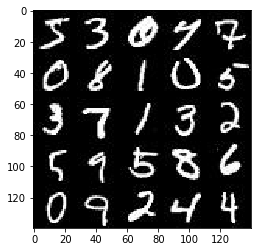

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

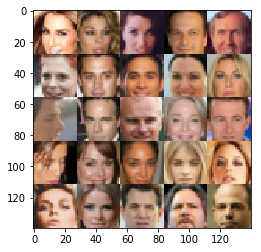

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
     # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
    #    h1 = tf.nn.dropout(h1, 0.5)
            
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
     #   h2 = tf.nn.dropout(h2, 0.5)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
      #  h3 = h3 = tf.nn.dropout(h3, 0.5)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
     # TODO: Implement Function
    
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
   
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
     #   h1 = tf.nn.dropout(h1, 0.5)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
      #  h2 = tf.nn.dropout(h2, 0.5)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
       # h3 = tf.nn.dropout(h3, 0.5)
            
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
   
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
     # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 6.3088
Epoch 1/2... Discriminator Loss: 5.1882... Generator Loss: 18.4522
Epoch 1/2... Discriminator Loss: 0.0241... Generator Loss: 6.9306
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.4670
Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 4.4941
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 4.3471
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.2934... Generator Loss: 3.4269
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.8485


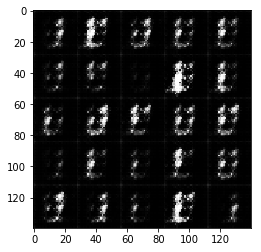

Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.5656
Epoch 1/2... Discriminator Loss: 1.5645... Generator Loss: 6.5623
Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 1.0678
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 1.8676
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 7.0315
Epoch 1/2... Discriminator Loss: 2.8713... Generator Loss: 0.1244
Epoch 1/2... Discriminator Loss: 0.2747... Generator Loss: 2.3654
Epoch 1/2... Discriminator Loss: 0.2805... Generator Loss: 3.8824
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 1.0816


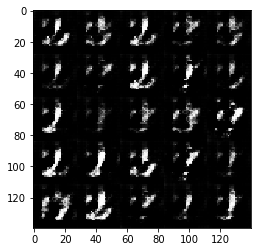

Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 2.0726... Generator Loss: 0.2028
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 3.6119
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.4966
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 3.4690
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 2.2281


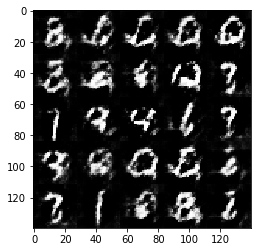

Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 2.4123
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 1.3960
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.4541
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.6229
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.2621
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.4423
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.4249


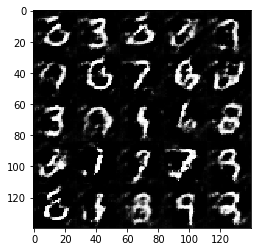

Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.4101
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.5842
Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.5207
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.9571
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 0.7434


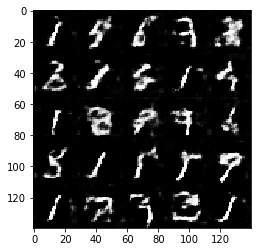

Epoch 1/2... Discriminator Loss: 2.1945... Generator Loss: 2.7589
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 1.9235
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.9582
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 2.2610
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 1.7563
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.3715


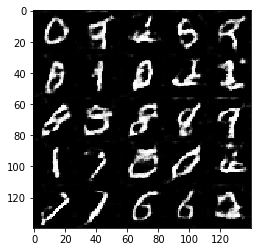

Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 1.7849
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 0.3030
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.3017
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 1.5368
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.4644
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.4682
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.4365
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 1.5839


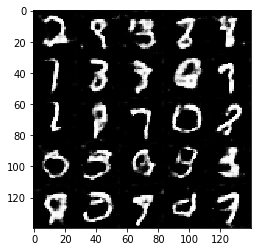

Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.4274
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 2.0067
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 1.4598
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.0802


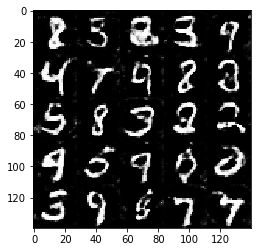

Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 1.6399
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.9265... Generator Loss: 0.2079
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.7740
Epoch 1/2... Discriminator Loss: 1.9987... Generator Loss: 0.2059
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.1325


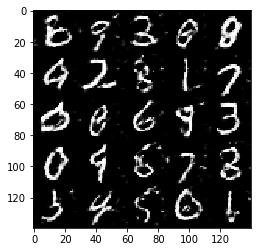

Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.5372
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.7525... Generator Loss: 0.2521
Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.4105
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 1.6328... Generator Loss: 0.2896
Epoch 2/2... Discriminator Loss: 1.5299... Generator Loss: 0.3695


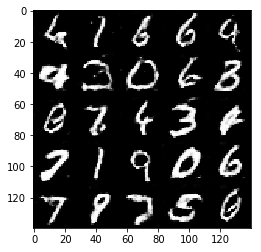

Epoch 2/2... Discriminator Loss: 1.5851... Generator Loss: 0.3465
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.5890
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 1.6084... Generator Loss: 0.3050
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.9048
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 2.1002
Epoch 2/2... Discriminator Loss: 1.6116... Generator Loss: 2.2903
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 0.9981


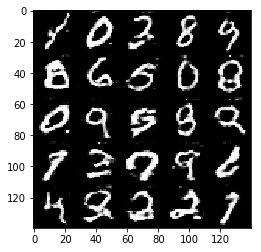

Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.9009... Generator Loss: 0.2448
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.3854
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.4498
Epoch 2/2... Discriminator Loss: 1.5903... Generator Loss: 0.3199
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.5395
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.3231


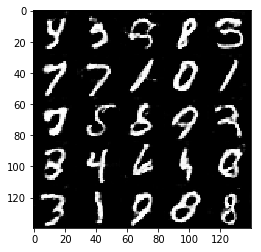

Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.5724
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 1.8965
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 1.6602
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 1.8892
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 1.4199


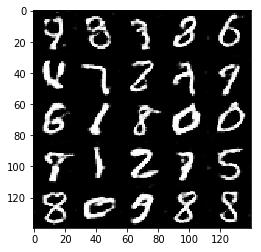

Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 1.3135
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 1.7280... Generator Loss: 0.2953
Epoch 2/2... Discriminator Loss: 1.7684... Generator Loss: 0.2707
Epoch 2/2... Discriminator Loss: 1.4855... Generator Loss: 0.3782
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.3411
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.9941


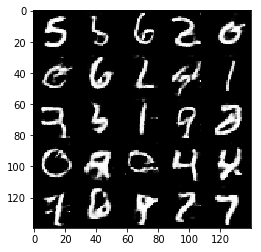

Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.5458
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.5949
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.4434
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.9501... Generator Loss: 0.1992
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.6936... Generator Loss: 0.2878
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.4533


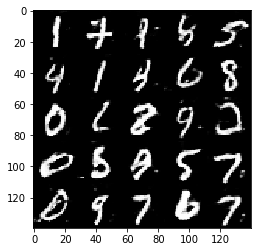

Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 1.6872
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.4434
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.6508
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 2.3264
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.5525
Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 2.3768
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 1.6472... Generator Loss: 0.2759


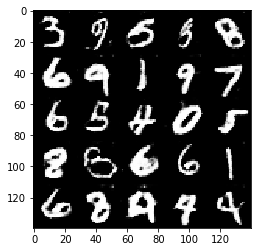

Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.3348
Epoch 2/2... Discriminator Loss: 1.6124... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 1.6498... Generator Loss: 0.2617
Epoch 2/2... Discriminator Loss: 1.7244... Generator Loss: 0.2658


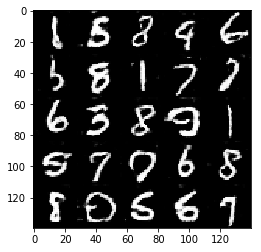

Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 1.7831... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.5976
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.3504
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 0.5912... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 1.0482


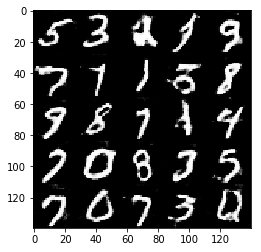

Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 1.6777... Generator Loss: 0.2797
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.8622... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.7437... Generator Loss: 0.2430


In [14]:
#batch_size = 64
#z_dim = 100
#learning_rate = 0.0005
#beta1 = 0.5

batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 17.6145
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 10.9644
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 4.2975
Epoch 1/1... Discriminator Loss: 2.2907... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.8001... Generator Loss: 0.2847
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.9956
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.8195


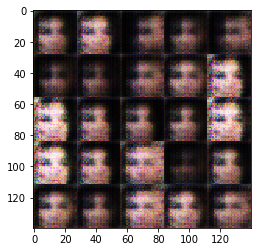

Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.1808
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.7898
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.8079... Generator Loss: 0.2463
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 1.3331


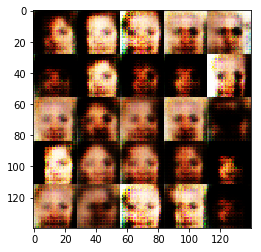

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.9297
Epoch 1/1... Discriminator Loss: 2.0813... Generator Loss: 0.1911
Epoch 1/1... Discriminator Loss: 2.0738... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 3.2654
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 1.9958
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.1389


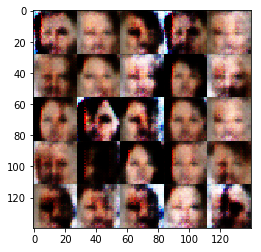

Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.7979... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 1.8946
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.3313


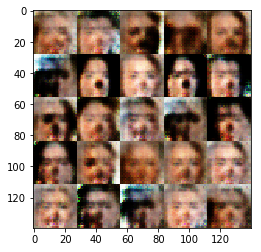

Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.3098
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.8997
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.5778
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.0882


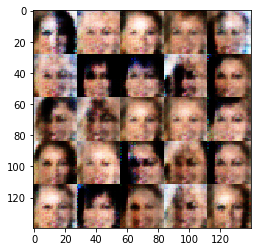

Epoch 1/1... Discriminator Loss: 1.9085... Generator Loss: 0.1958
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6534


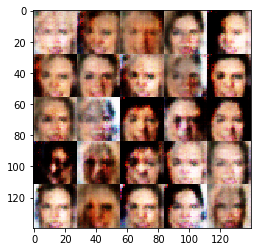

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.9568... Generator Loss: 2.5018
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 2.3290... Generator Loss: 2.4716
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.6165


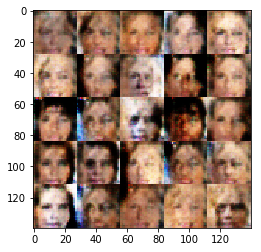

Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.7623


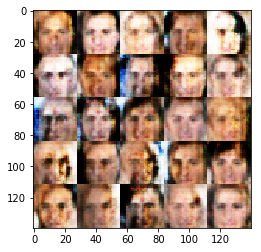

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.6123
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.9298
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.8866... Generator Loss: 2.6730
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.0223


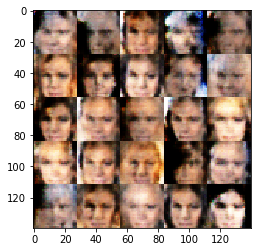

Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 2.1423... Generator Loss: 2.0045
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 2.0114
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9937


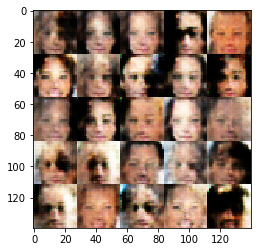

Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.7825... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.6214


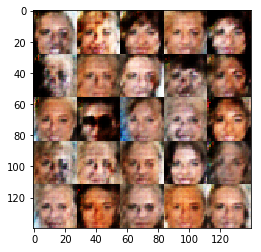

Epoch 1/1... Discriminator Loss: 1.9502... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 2.7433
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.2905


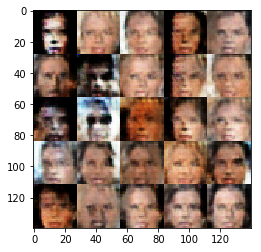

Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 3.0420
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.3074
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.2846


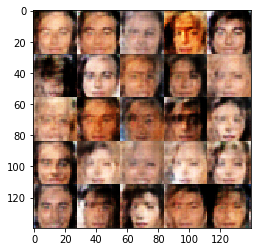

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5771


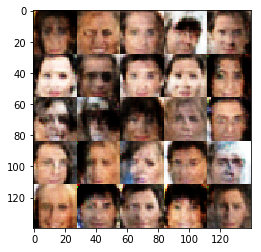

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 1.9622
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 2.4140
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.4060


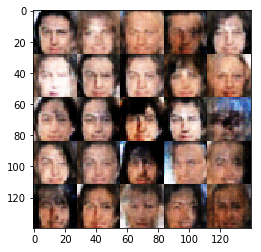

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.1438


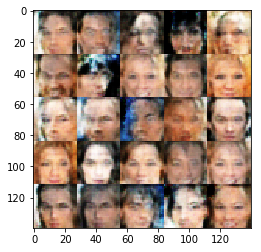

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.8753... Generator Loss: 0.2130
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.5803


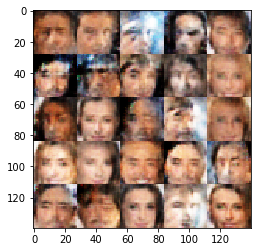

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8898


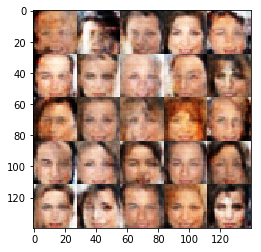

Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.3160
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6154


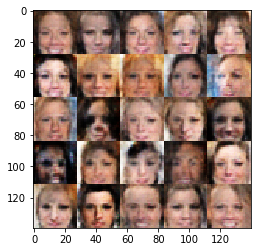

Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.7455... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.6876... Generator Loss: 2.2233


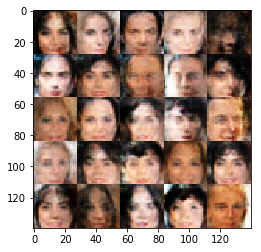

Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 1.9057... Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8291


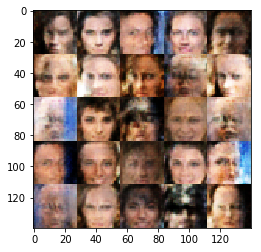

Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.7581... Generator Loss: 0.2375
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.7674


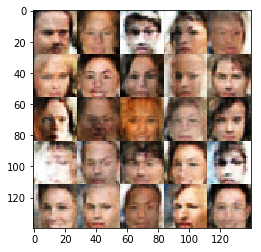

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8953


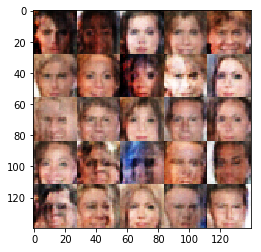

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7616


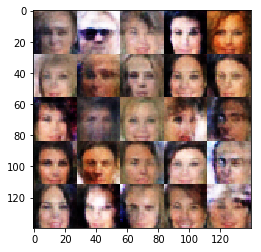

Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 2.0215... Generator Loss: 0.3451
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.8982... Generator Loss: 0.2217


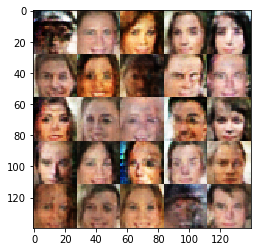

Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.6717... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.9929
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8397


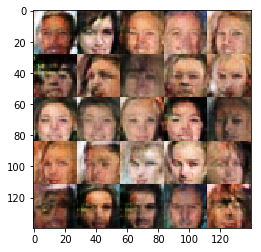

Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.4915


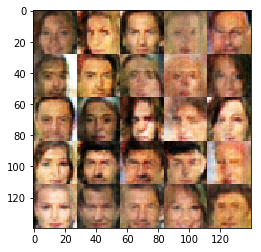

Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.3065
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6484


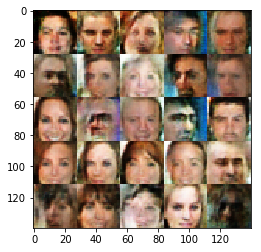

Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.2415
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.4638


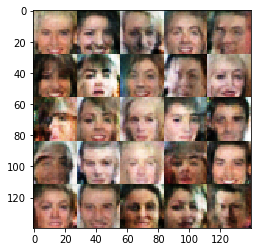

Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4767


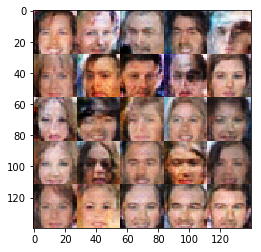

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.7684... Generator Loss: 0.2566


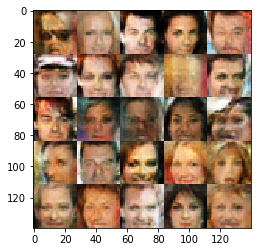

Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.5076


In [15]:
#batch_size = 32
#z_dim = 100
#learning_rate = 0.002
#beta1 = 0.5


batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.2



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.